In [20]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util
import os
import numpy as np
from tensorflow.keras import callbacks
import warnings
import pandas as pd
warnings.simplefilter("ignore")

# Load data
data_folder = os.path.join('..', 'data')
data = util.load_cmapss_data(data_folder)

# Focus on a subset of the data
data_by_src = util.split_by_field(data, field='src')
dt = data_by_src['train_FD004']

# Split training and test machines
tr_ratio = 0.75
np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep = int(tr_ratio * len(machines))
tr_mcn = machines[:sep]
ts_mcn = machines[sep:]

tr, ts = util.partition_by_machine(dt, tr_mcn)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Probabilistic RUL Estimatation

## RUL Estimation, Again

**Let's consider again our RUL-based policy use case**

We first tackled that by using a regressor to estimate this kind of function:

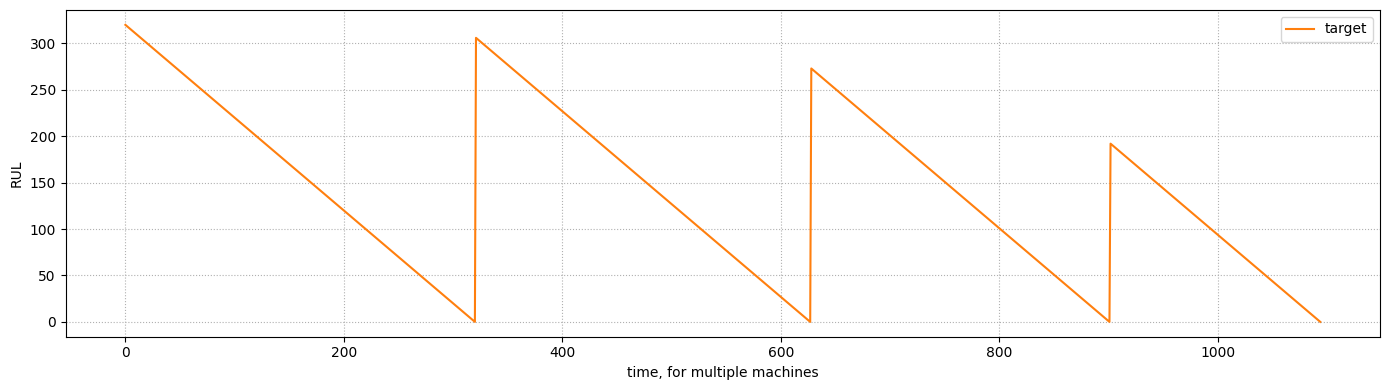

In [21]:
stop = 1095
util.plot_rul(target=tr['rul'][:stop], figsize=figsize, xlabel='time, for multiple machines', ylabel='RUL')

...Then we tuned a threshold to define a simple maintenance policy

<div class=big><small>It worked well enough, but not perfectly</small><br>What did we fail to achieve?</div>

## Limitations

**The RUL estimation was of very poor quality**

* Our model was good enough for defining a policy
* ...But not usable to provide a real-time RUL estimate

**Why did we fail? Here are a few potential culprits**

* Are we sure our target is correct? What if the defect arises late?
* Our target looks deterministic: are we accounting for uncertainty?
* Are we providing all the necessary input?

It's not easy to tell where the problem lays

**...Because _we didn't think enough_ before solving!**

## Back to the Drawing Board

**Here's what the correct approach should be:**

* We start by defining a _probabilistic model_
* We use _ML to approximate_ key components of such model
* We use the model + the approximators to make _probabilistic predictions_

**This approach can be significantly more challenging**

...But it comes with several benefits:

* You have both predictions _and confidence_
* You exploit a degree of _domain knowledge_
* You get a _more interpretable_ model
* If you choose to _ignore_ an element (e.g. because it is too difficult to model)
* ...At least you _know_ that you have done so

## A Survival Analysis Model

**We are interested in the "survival time" of an entity**

We can start by modeling that as a single random variable $T$ with unknown distribution

$$
T \sim P(T) \qquad \text{(draft 1)}
$$

* $T$ (with $\mathbb{R}^+$ as support) represents the survival time

**To be specific, we want $T$ to be _remaining_ survival time**

...With respect to time $t$ when we perform the estimation. Formally:

$$
T \sim P(T \mid t)  \qquad \text{(draft 2)}
$$

* Now the distribution is conditioned on $t$ (which we can access)

## A Survival Analysis Model

**Survival depends on additional factors**

E.g. on the lifestyle of a person, or on how industrial equipment is used

* We can model these factors as additional random variables
* We can distinguish between behavior in the past $X_{\leq t}$ and the future $X_{>t}$

**Formally, we have:**

$$
T \sim P(T \mid X_{\leq t}, t, X_{> t})  \qquad \text{(draft 3)}
$$

For now we focus on _capturing the elements that affect the estimate_

* We not not care (yet) about the fact that we can access them
* The idea is to focus on _one problem at a time_

## A Survival Analysis Model

**...But of course whether a quantity can be accessed or not does matter**

In particular, _future behavior cannot be accessed_ at estimation time

* Intuitively, future behavior affects the estimate as _noise_
* Formally, we can _average out_ its effect

**This operation is called _marginalization_ and leads to:**

$$
T \sim \mathbb{E}_{X_{> t}} \left[ P(T \mid X_{\leq t}, t, X_{> t}) \right]  \qquad \text{(draft 4)}
$$

This is a good model for the distribution of the variable we wish to estimate

* The "sawtooth like" target that we used earlier for RUL regression
* ....Corresponds to _samples from $P(T \mid X_{\leq t}, t, X_{> t})$_

<div class="big"><small>In other words, we are saying our target was correct!</small><br>So, why did we get strange results in the RUL lecture?</div>

## Looking Back to Our Model

**In the RUL lecture we trained a regressor**

...With the current parameters/sensors as input and an MSE loss

* Meaning the _our estimator_ is making implicitly use of this model:

$$
T \sim \mathcal{N}(\mu(X_{t}), \sigma)
$$

* $\mathcal{N}$ denotes the Normal distribution, $\mu(\cdot)$ represents our old regressor

**Now, compare it with our "ideal" probabilistic model:**

$$
T \sim \mathbb{E}_{X_{> t}} \left[ P(T \mid X_{\leq t}, t, X_{> t}) \right]
$$

* Let's try to spot together any major difference

## Implicit Assumptions

**We made several implicit assumptions:**

$$
T \sim \mathcal{N}(\mu(X_{t}), \sigma) \quad \text{vs} \quad T \sim \mathbb{E}_{X_{> t}} \left[ P(T \mid X_{\leq t}, t, X_{> t}) \right]
$$

We considered _a single $X_{t}$_, rather than $X_{\leq t}$

* Actually, we tried that by using sequence input (it helped, but not much)

We _disregarded time_ as an input

* ...And thankfully this is easy to fix

We assumed a _Normal distribution_ with _fixed variance_

* It's unclear how to relax the normality assumption
* ...But we know we can fix the variance this using a neuro-probabilistic model!

## About Time

**Let's fix one mistake by adding _time as an input_**

In our dataset, time corresponds to the "cycle" field

In [22]:
# Identify parameter and sensor columns
dt_in = list(data.columns[3:-1])

# Standardize parameters and sensors
trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields
ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = tr.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd

# Normalize RUL and time (cycle)
trmaxrul = tr['rul'].max()
ts_s['cycle'] = ts_s['cycle'] / trmaxrul
tr_s['cycle'] = tr_s['cycle'] / trmaxrul
ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul

# Add time (cycle) to the input columns
dt_in = dt_in + ['cycle']

## Estimated Variance

**Then we can make our ML model capable of _estimating variance_**

In particular, we can use a neuro-probabilistic ML model

* The underlying probabilistic model is:

$$
T \sim \mathcal{N}(\mu(X_t, t), \sigma(X_t, t))
$$

In practice:

* We use conventional ML model (a network) to estimate $\mu$ and $\sigma$
* ...Then we feed both parameters to a `DistributionLambda` layer

**Our model will be able to learn how $\sigma$ depends on the input**

* This will be more challenging, but also more flexible
* ...And it will provide us confidence intervals

## Building a Neuro-Probabilistic Model

**Code to build the model can found in the `util` module**

```python
def build_nn_normal_model(input_shape, hidden, stddev_guess=1):
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    mu_logsigma = layers.Dense(2, activation='linear')(x)
    lf = lambda t: tfp.distributions.Normal(loc=t[:, :1], scale=tf.math.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsigma)
    model = keras.Model(model_in, model_out)
    return model
```

* Note the way the input tensor `t` is split in the `lambda` function
* That is needed to obtain the correct tensor shapes (columns)

## Building a Neuro-Probabilistic Model

**Let's build a simple neuro-probabilistic model**

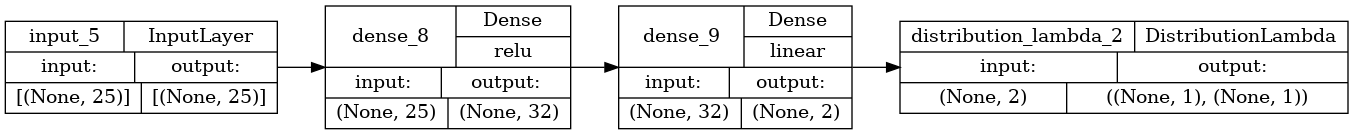

In [23]:
tr_rul_std = tr_s['rul'].std()
nnp = util.build_nn_normal_model(input_shape=(len(dt_in), ), hidden=[32], stddev_guess=tr_rul_std)
util.plot_nn_model(nnp)

* There is a single hidden layer
* As a guess for $\sigma$, we provide the standard deviations over the training set

## Training the Neuro-Probabilistic Model

**We can train the model as in our previous example**

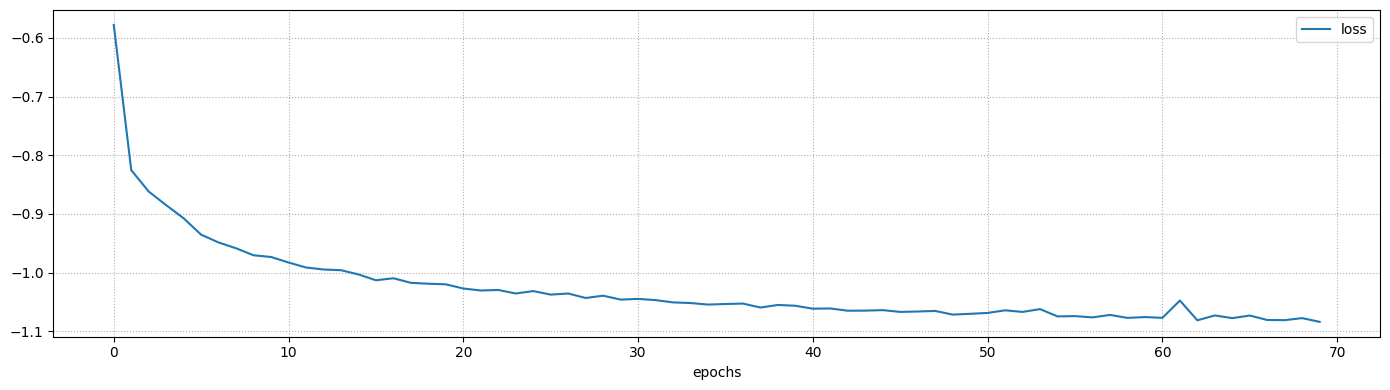

Final loss: -1.0840 (training)


In [25]:
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)
nnp = util.build_nn_normal_model(input_shape=(len(dt_in), ), hidden=[32], stddev_guess=tr_rul_std)
history = util.train_nn_model(nnp, tr_s[dt_in], tr_s['rul'], loss=negloglikelihood, epochs=70, verbose=0, patience=10, batch_size=32, validation_split=0.0)
util.plot_training_history(history, figsize=figsize)

## Evaluation

**We care about the estimated distributions (not about sampling)**

...Therefore we call the model rather than using the `predict` method

In [26]:
nn_pred_ts = nnp(tr_s[dt_in].values)
nn_pred_ts

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[45385, 1] event_shape=[] dtype=float32>

**From the distribution objects we can obtain means and standard deviations**

In [27]:
np_pred_ts_mean = nn_pred_ts.mean().numpy().ravel() * trmaxrul
np_pred_ts_std = nn_pred_ts.stddev().numpy().ravel() * trmaxrul

* For sake of keeping it short, we will just inspect the predictions
* ...Rather than making a full evaluation

That said, we could do it (and the results would be similar to the old ones)

## Evaluation

**Let's inspect the predictions on a portion of the test set**

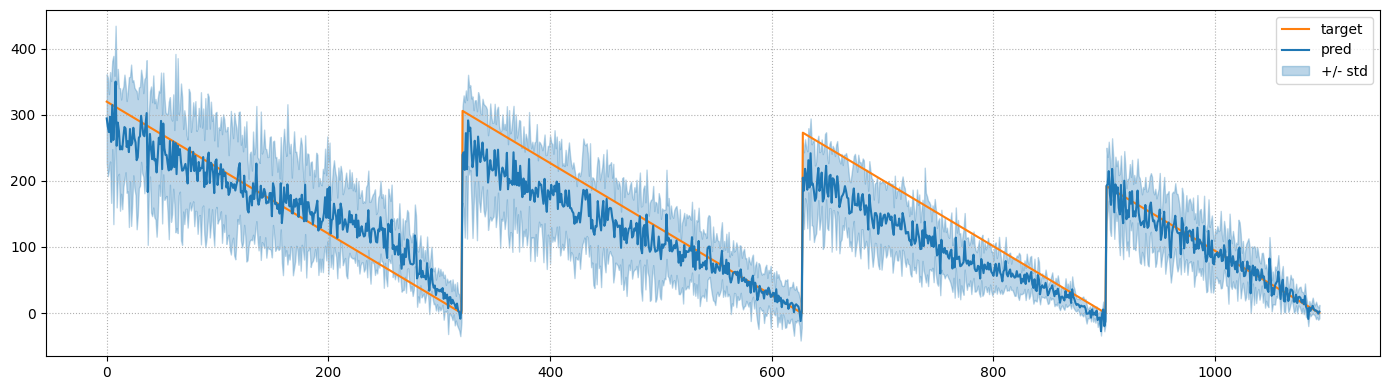

In [28]:
stop = 1095
util.plot_rul(target=tr_s['rul'].iloc[:stop]*trmaxrul, pred=np_pred_ts_mean[:stop],
              stddev=np_pred_ts_std[:stop], figsize=figsize)

* The initial plateaus in the predictions have disappeared
* ...And the true RUL is typically within 1$\sigma$ from the predicted mean

## Neuro-probabilistic Models vs Sample Weights

**The approach we have seen works already very well**

* We get a predicted mean (as usual)
* ...But also an input-dependent standard deviation

> **But can't we do the same with sample weights?**

**Yes, but it's not the same**

* Sample weights allow use to control the standard deviation with an MSE loss
* ...But we need to _pre-compute them_ using another model (or assumption)

**They cannot be learned in an end-to-end fashion!**